In [1]:
import sys
import shap
from torch.utils.data import DataLoader
import joblib
import matplotlib.pyplot as plt

sys.path.append("../")
import xfinai_config
from data_layer.base_dataset import FuturesDatasetRecurrent
from model_layer.model_hub import *
from utils import base_io
from shap_explain import Seq2SeqSHAPExplainer
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'

In [2]:
shap.initjs() 

## Analysis Shap Values

In [3]:
shap_values = joblib.load("./shap_values/IC_EncoderGRU_AttnDecoderGRU_shap_values.pkl")
explain_data_random_batch = joblib.load('./shap_values/IC_EncoderGRU_AttnDecoderGRU_explain_data_random_batch.pkl')
explainer = joblib.load('./shap_values/IC_EncoderGRU_AttnDecoderGRU_explainer.pkl')             

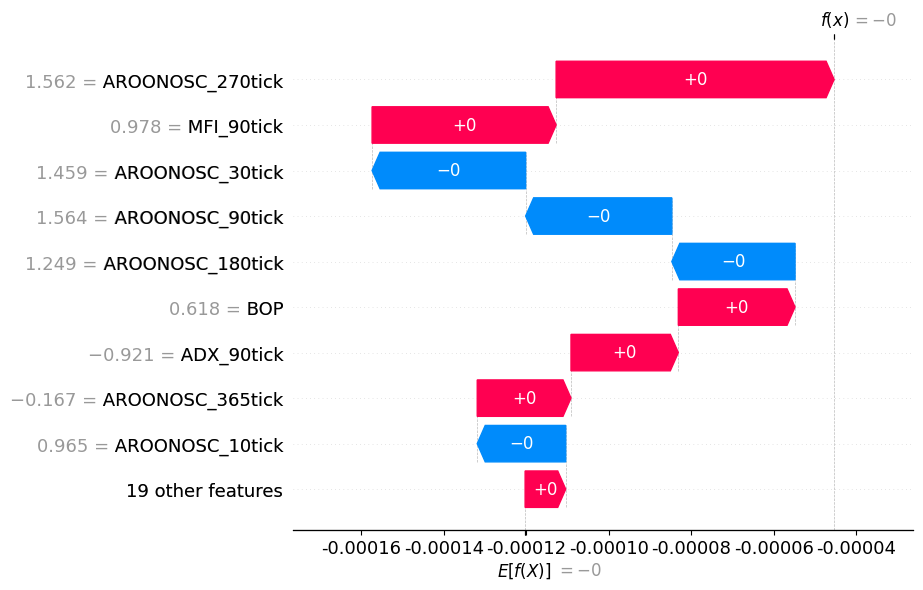

In [11]:
plt.figure(figsize=[6,4], dpi=100)
shap.plots.waterfall(shap_values[473], max_display=10)

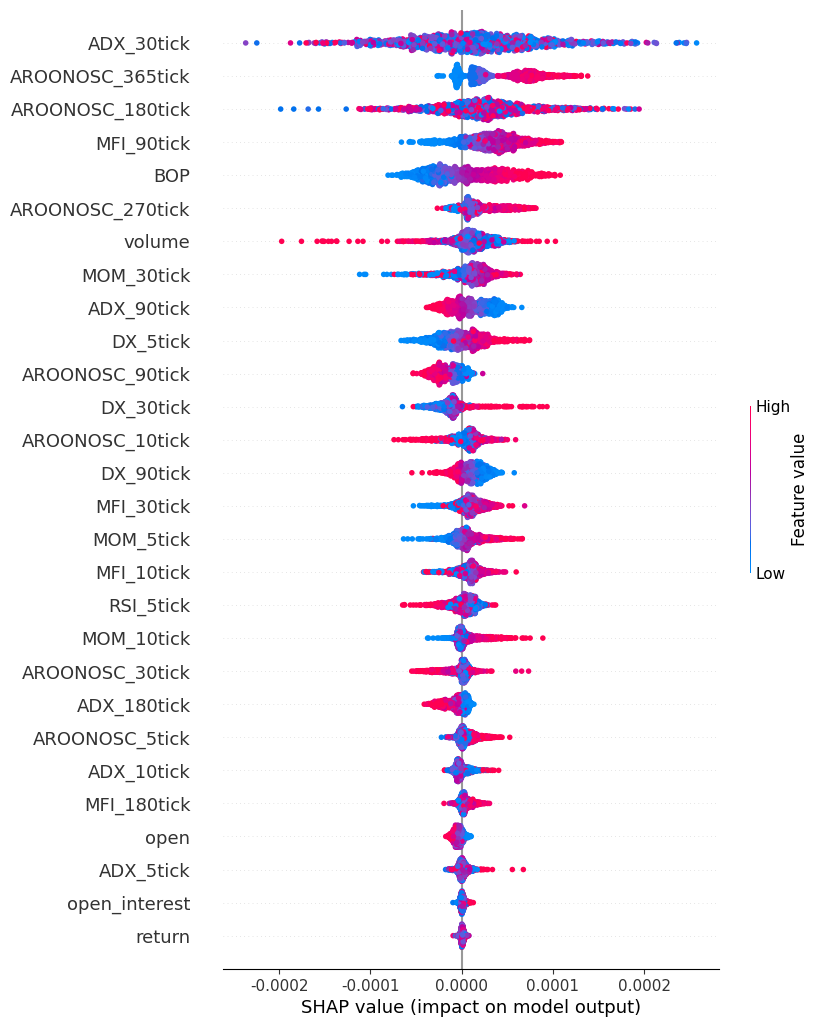

In [16]:
plt.figure(figsize=[6,4], dpi=100)
shap.plots.beeswarm(shap_values, max_display=30)

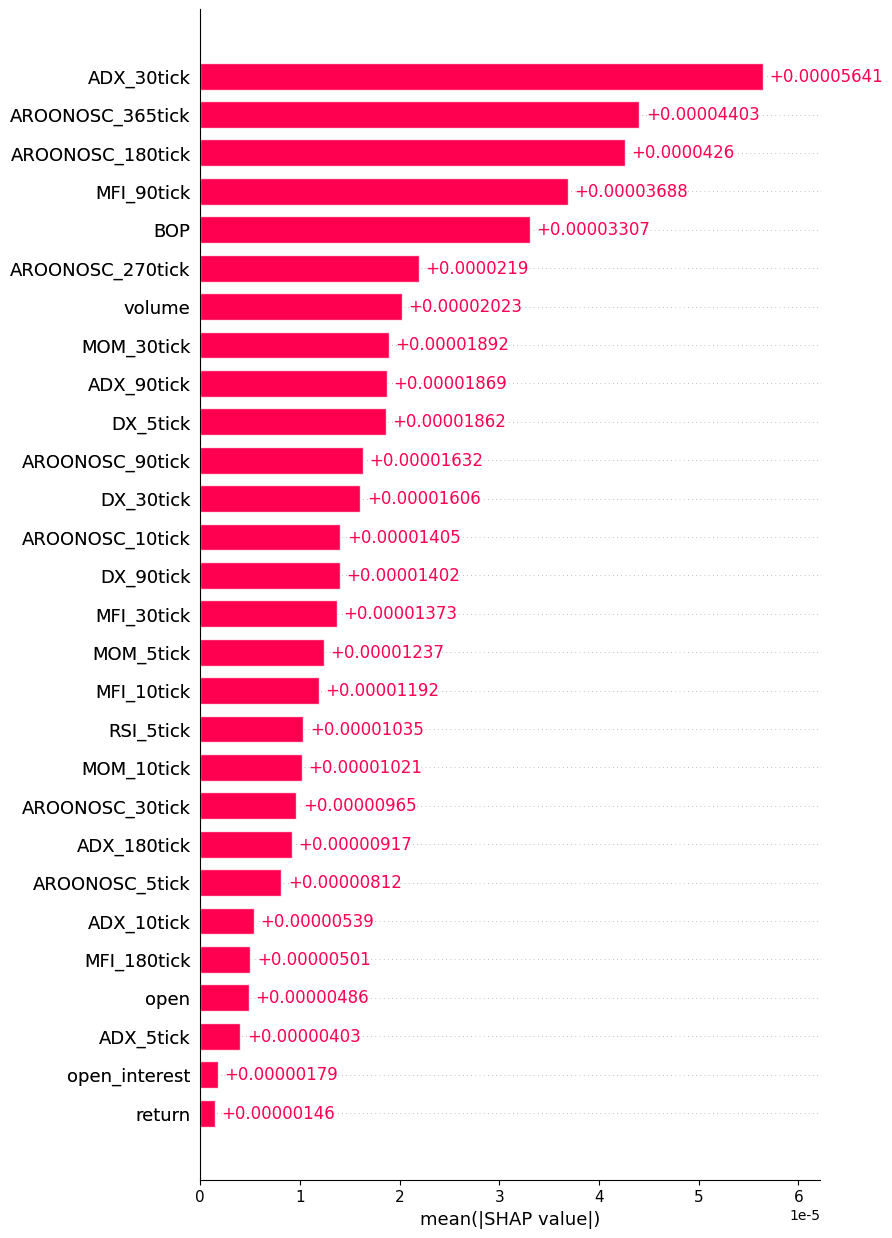

In [15]:
plt.figure(figsize=[6,4], dpi=100)
shap.plots.bar(shap_values, max_display=30)

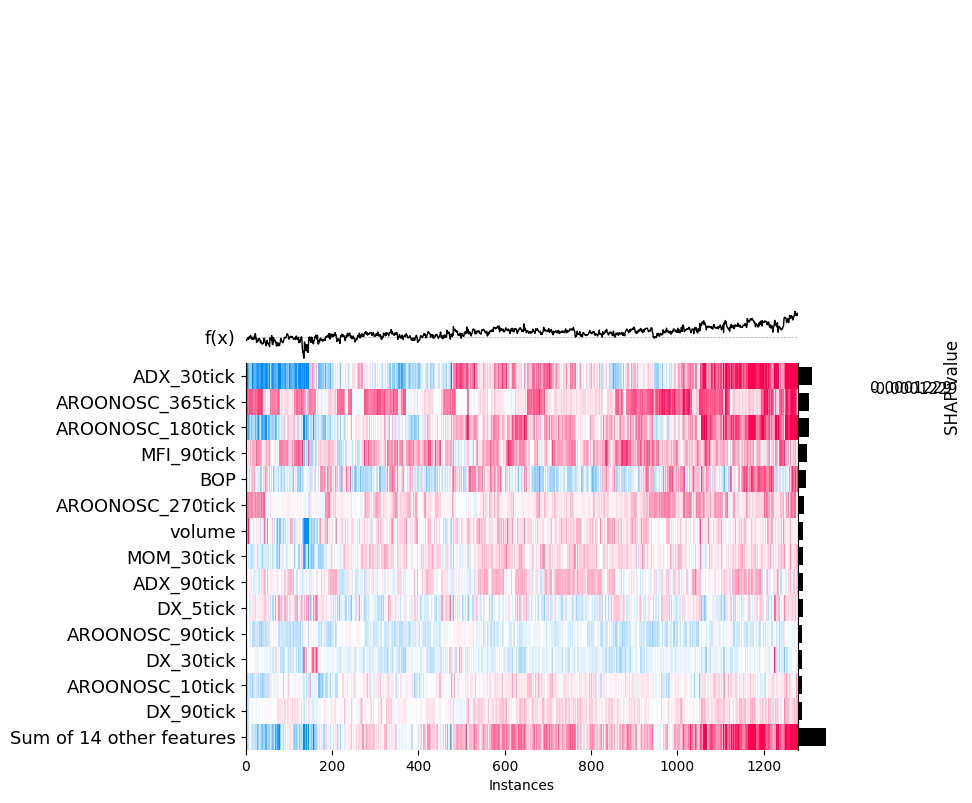

In [17]:
plt.figure(figsize=[6,4], dpi=100)
shap.plots.heatmap(shap_values, max_display=15)